### Assignment 3

Yingnan Zhao 260563769

In [1]:
import collections
import csv
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.dummy import DummyClassifier
import warnings; warnings.simplefilter('ignore')

#### Question 1

The function below removes the special eharacters from the input data array.(string array)

In [2]:
def preprocessing(data):
    df = pd.read_csv(data, sep='delimiter', header=None, engine='python')
    df = df[0]
    for i in range(len(df)):
        df[i] = re.sub(r'[^\w]', ' ', str.lower(df[i]))
    return df

The function below uses the counter in the collections library to find the most common 10000 words in the input string array and store then in the designated location

In [3]:
def buildVocabulary(dataset, storageLocation):  # 'datasets//yelp-vocab.csv'
    dataset = preprocessing(dataset)
    topWords = collections.Counter()
    for comments in dataset:
        words = comments.split()[:-1]
        topWords.update(words)
    topWords = topWords.most_common(10000)
    Vocabulary = {}
    with open(storageLocation, 'w', newline='') as csvfile:
        csvWriter = csv.writer(csvfile, delimiter='\t', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for j in range(len(topWords)):
            csvWriter.writerow([topWords[j][0], j, topWords[j][1]])
            Vocabulary[topWords[j][0]] = ((j, topWords[j][1]))
    return Vocabulary

The function below transforms an array of strings(comments) in to reviews according to the vocabulary built by last function, so each words in a reviews is represented by the ID of that word in the vocabulary, the reviews will be stored in the designated location, at the end of each review the score is stored after a tab. This function enables us to store the data in a more efficient way and use sparse matrix.

In [4]:
def buildReview(dataset, vocabulary,storageLocation):
    dataset = preprocessing(dataset)
    reviews = []
    scores = []
    for comment in dataset:
        words = comment.split()
        row = []
        for k in range(len(words)-1):
            res = vocabulary.get(words[k],-1)
            if (res != -1):
                row.append(res[0])
        if(len(row)>0):
            reviews.append(row)
            scores.append(words[len(words)-1])
    with open(storageLocation, 'w', newline='') as csvfile:
        csvWriter = csv.writer(csvfile, delimiter=' ')
        for j in range(len(reviews)):
            row = []
            for i in range(len(reviews[j])):
                row.append(reviews[j][i])
            row.append('\t'+scores[j])
            csvWriter.writerow(row)
    return (reviews,scores)

Here we build the reviews for each of the datasets of IMDB and Yelp respectively, all of the reviews are stored in the outputdatasets folder

In [5]:
vocab = buildVocabulary('datasets//IMDB-train.txt','outputdatasets//IMDB-vocab.txt')
buildReview('datasets//IMDB-train.txt',vocab,'outputdatasets//IMDB-train.txt')
buildReview('datasets//IMDB-test.txt',vocab,'outputdatasets//IMDB-test.txt')
buildReview('datasets//IMDB-valid.txt',vocab,'outputdatasets//IMDB-valid.txt')
vocab = buildVocabulary('datasets//yelp-train.txt','outputdatasets//yelp-vocab.txt')
buildReview('datasets//yelp-train.txt',vocab,'outputdatasets//yelp-train.txt')
buildReview('datasets//yelp-test.txt',vocab,'outputdatasets//yelp-test.txt')
buildReview('datasets//yelp-valid.txt',vocab,'outputdatasets//yelp-valid.txt')


SyntaxError: invalid syntax (<ipython-input-5-17108d7bf952>, line 8)

The function Below reads the reviews from txt files, the review and score will be returned as two independ lists.

In [6]:
def readReviews(reviewPath):
    df = pd.read_csv(reviewPath, sep='\t',names=['review','score'], engine='python')
    review = []
    for line in df['review']:
        row = line.split()
        review.append(np.array(row).astype(np.float))
    score = np.array(df['score']).astype(np.float)
    return (review,score)

This function transform the reviews in to a binary bag of word where each feature in the vocabulary is one column

In [7]:
def getBinaryBagOfWord(reviews):
    row = []
    col = []
    value = []
    length = len(reviews)
    for i in range(len(reviews)):
        temp = set()
        for j in range(len(reviews[i])):
            if(reviews[i][j] not in temp):
                temp.add(reviews[i][j])
                col.append(reviews[i][j])
                row.append(i)
                value.append(1)
    BBWMatrix = sparse.bsr_matrix((value, (row, col)))
    if(BBWMatrix.shape[1]!=10000):
        BBWMatrix = sparse.bsr_matrix((BBWMatrix.data, BBWMatrix.indices, BBWMatrix.indptr),shape=(length, 10000))
    # BBWMatrix = BBWMatrix.toarray()
    return BBWMatrix

This function transform the reviews in to a frequency bag of word where each feature in the vocabulary is one column, and the sum of each row equals to 0.

In [8]:
def getFreqBagOfWord(reviews):
    row = []
    col = []
    value = []
    for i in range(len(reviews)):
        temp = []
        tempValue = []
        for j in range(len(reviews[i])):
            if(reviews[i][j] not in temp):
                temp.append(reviews[i][j])
                col.append(reviews[i][j])
                row.append(i)
                tempValue.append(1/len(reviews[i]))
            else:
                k = temp.index(reviews[i][j])
                tempValue[k]+=1/len(reviews[i])
        value += tempValue
    FBWMatrix = sparse.bsr_matrix((value, (row, col)))
    if (FBWMatrix.shape[1]!=10000):
        FBWMatrix = sparse.bsr_matrix((FBWMatrix.data, FBWMatrix.indices, FBWMatrix.indptr), shape=(len(reviews), 10000))
    # FBWMatrix = FBWMatrix.toarray()
    return FBWMatrix

### Question 2

The functions below use different strategy(uniform random and majority) of the dummy classifier from sklearn and classify the imput data to serve as a base line.

In [41]:
def randomClassifier(trainingX,trainingY,testingX,testingY):
    clfUniform = DummyClassifier(strategy='uniform')
    clfUniform.fit(trainingX, trainingY)
    preditYUniform = []
    for i in range(len(testingX)):
        ans1 = clfUniform.predict([testingX[i]])
        preditYUniform.append(ans1)
    print('Uniform Random F1 Score= ' + str(metrics.f1_score(testingY, preditYUniform, average='weighted')))
def mostFrequentClassifier(trainingX,trainingY,testingX,testingY):
    clfUniform = DummyClassifier(strategy='most_frequent',random_state=0)
    clfUniform.fit(trainingX, trainingY)
    preditYUniform = []
    for i in range(len(testingX)):
        ans1 = clfUniform.predict([testingX[i]])
        preditYUniform.append(ans1)
    print('Most Frequent F1 Score= ' + str(metrics.f1_score(testingY, preditYUniform, average='weighted')))

Get the yelp train, validation and test data set ready in binary bag of words representation, as well as the scores.

In [16]:
trainResult = readReviews('outputdatasets//yelp-train.txt')
trainX = getBinaryBagOfWord(trainResult[0])
trainY = trainResult[1]
testResult = readReviews('outputdatasets//yelp-valid.txt')
testX = getBinaryBagOfWord(testResult[0]).toarray()
testY = testResult[1]
testResultFinal = readReviews('outputdatasets//yelp-test.txt')
testXFinal = getBinaryBagOfWord(testResultFinal[0]).toarray()
testYFinal = testResultFinal[1]

set the baseline using the random classifier and the majority classifier

In [44]:
mostFrequentClassifier(trainX,trainY,testXFinal,testYFinal)
randomClassifier(trainX,trainY,testXFinal,testYFinal)

Most Frequent F1 Score= 0.182384900074
Uniform Random F1 Score= 0.212874083355


The function below plots F1 score vs the hyper parameter training

In [9]:
def plotHyperparameterTrainingProgress(input):
    a = np.array(input,dtype='float')
    a = np.transpose(a)
    plt.plot(a[1], a[0], 'bo')
    plt.title('Selecting HyperParameter')
    plt.xlabel('Hyperparameter')
    plt.ylabel('F1 Score')
    plt.show()

The function uses the decision tree classifier from sklearn and return the weight F1 score. There are three hyper-parameter to be adjusted, maximum number of leaf, the minimum percentage of samples required to split an internal node, and the number of features to consider when looking for the best split.

In [10]:
def decisionTree(trainingX, trainingY, testingX, testingY, maxLeaf,min_samples_split, max_features):
    clf = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=maxLeaf, min_samples_split = min_samples_split)
    clf.fit(trainingX, trainingY)
    preditY = []
    for i in range(len(testingX)):
        ans = clf.predict([testingX[i]])
        preditY.append(ans)
    f1Score = metrics.f1_score(testingY, preditY, average='weighted')
    return f1Score

A grid search has been done to find the best combinations of the three hyperparameters. For the maximum number of leaf feature I considered the range from 300 to 100, the maximum feature parameter I considered from 1 to 0.5 the min sample split I considered from 0.1 to 0.00097

In [11]:
f1s = []
for i in range (300,100,-10):
    max_features = 1.0
    for j in range(10):
        min_sample_split = 1.0
        for k in range (10):
            f1s.append([decisionTree(trainX,trainY,testX,testY,i,min_sample_split,max_features),i,min_sample_split,max_features])
            min_sample_split *= 0.5
        max_features -= 0.05
f1s.sort()
print('the optimal number of leafs is '+str(f1s[len(f1s)-1][1])+', min sample split is:'
      + str(f1s[len(f1s)-1][2]) +', max features is :'+str(f1s[len(f1s)-1][3])+', it achieves a F1 score of '+ str(f1s[len(f1s)-1][0]))

the optimal number of leafs is 200, min sample split is:1.0, max features is :1.0, it achieves a F1 score of 0.380983427942


Applying the optimal hyperparameters learnt to the test set.

In [97]:
f1Test = decisionTree(trainX,trainY,trainX.toarray(),trainY,200,1.0,1.0)
print('The F1 score of decision Tree for yelp train set frequency bag of word representation is '+ str(f1Test))
f1Test = decisionTree(trainX,trainY,testX,testY,200,1.0,1.0)
print('The F1 score of decision Tree for yelp valid set frequency bag of word representation is '+ str(f1Test))
f1Test = decisionTree(trainX,trainY,testXFinal,testYFinal,200,1.0,1.0)
print('The F1 score of decision Tree for yelp test set frequency bag of word representation is '+ str(f1Test))

The F1 score of decision Tree for yelp train set frequency bag of word representation is 0.518072088109
The F1 score of decision Tree for yelp valid set frequency bag of word representation is 0.37935513571
The F1 score of decision Tree for yelp test set frequency bag of word representation is 0.383476156155


The function below uses the Bernoulli Native Bayes classifier to classify the data, there is one hyper parameter to be adjusted, which is Additive (Laplace/Lidstone) smoothing parameter, aplha.

In [11]:
def BernoulliNativeBayes(trainingX,trainingY,testingX,testingY,a):
    clf = BernoulliNB(alpha=a)
    clf.fit(trainingX, trainingY)
    preditY = []
    hit = 0
    for i in range(len(testingX)):
        ans = clf.predict([testingX[i]])
        if ans == testingY[i]:
            hit +=1
        preditY.append(ans)
    f1 = metrics.f1_score(testingY, preditY, average='weighted')
    # print('F1 Score = ' + str(f1))
    return f1

The optimal alpha will be find in the range from 0.7 to 0.0000225.

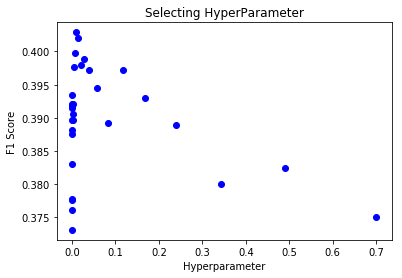

the optimal alpha is 0.009688901040699992, it achieves a F1 score of 0.4028932560404406


In [47]:
f1s = []
a = 1
for i in range(0,30):

    a *=0.7
    # print('alpha = '+str(a))
    f1s.append([BernoulliNativeBayes(trainX, trainY, testX, testY, a), a])
f1s.sort()
plotHyperparameterTrainingProgress(f1s)
print('the optimal alpha is ' + str(f1s[len(f1s)-1][1]) + ', it achieves a F1 score of ' + str(f1s[len(f1s)-1][0]))

Applying the optimal hyperparameters learnt to the test set.

In [90]:
f1Test = BernoulliNativeBayes(trainX, trainY,trainX.toarray(), trainY, 0.009688901040699992)
print('The F1 score of Native Bayes for yelp train set binary bag of word representation is '+ str(f1Test))
f1Test = BernoulliNativeBayes(trainX, trainY, testX, testY, 0.009688901040699992)
print('The F1 score of Native Bayes for yelp valid set binary bag of word representation is '+ str(f1Test))
f1Test = BernoulliNativeBayes(trainX, trainY, testXFinal, testYFinal, 0.009688901040699992)
print('The F1 score of Native Bayes for yelp test set binary bag of word representation is '+ str(f1Test))

The F1 score of Native Bayes for yelp train set binary bag of word representation is 0.740081113991
The F1 score of Native Bayes for yelp valid set binary bag of word representation is 0.40289325604
The F1 score of Native Bayes for yelp test set binary bag of word representation is 0.43113819783


The function below uses the linear SVM to classify the data, there are two hyperparameters to be considered, C is the penalty parameter of the error term, and dual is to select to either to solve the dual or primal optimization problem.

In [12]:
def LinearSVM(trainingX, trainingY, testingX, testingY, C,dual):
    clf = LinearSVC(C=C,dual=dual)
    clf.fit(trainingX, trainingY)
    preditY = []
    for i in range(len(testingX)):
        ans = clf.predict([testingX[i]])
        preditY.append(ans)
    f1Score = metrics.f1_score(testingY, preditY, average='weighted')
    return f1Score

Finding the best combination of the two hyperparameters. C is considered from 7 to  0.000225, dual is either True or False

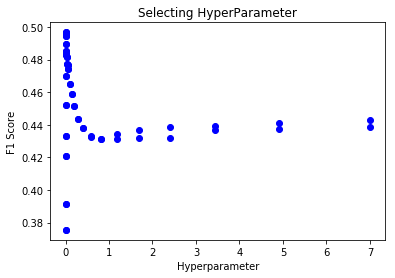

the optimal C is 0.007979226629761192, dual= True, it achieves a F1 score of 0.4967606230498824


In [61]:
C = 10
f1s=[]

for i in range(0, 30):
    C  *= 0.7
    # print('alpha = '+str(a))
    f1s.append([LinearSVM(trainX, trainY, testX, testY, C,False), C,'False'])
    f1s.append([LinearSVM(trainX, trainY, testX, testY, C,True), C,'True'])
    
f1s.sort()

plotHyperparameterTrainingProgress(np.array(f1s)[:,:-1])
print('the optimal C is ' + str(f1s[len(f1s) - 1][1]) +', dual= '+str(f1s[len(f1s) - 1][2])+', it achieves a F1 score of ' + str(f1s[len(f1s) - 1][0]))

Applying the optimal hyperparameters learnt to the test set.

In [91]:
f1Test = LinearSVM(trainX, trainY, trainX.toarray(), trainY, 0.007979226629761192, True)
print('The F1 score of LinearSVM for yelp train set binary bag of word representation is '+ str(f1Test))
f1Test = LinearSVM(trainX, trainY, testX, testY, 0.007979226629761192, True)
print('The F1 score of LinearSVM for yelp valid set binary bag of word representation is '+ str(f1Test))
f1Test = LinearSVM(trainX, trainY, testXFinal, testYFinal, 0.007979226629761192, True)
print('The F1 score of LinearSVM for yelp test set binary bag of word representation is '+ str(f1Test))

The F1 score of LinearSVM for yelp train set binary bag of word representation is 0.833265595284
The F1 score of LinearSVM for yelp valid set binary bag of word representation is 0.49676062305
The F1 score of LinearSVM for yelp test set binary bag of word representation is 0.501717243121


#### Comment about the performance of different classifers.

For the binary bag of word representation bag of word representation of the yelp set, Linear SVM Classifier gives the best result in all three datasets (train, valid, test), and decision gives the worst result, however without setting the hyperparameters to make the decision tree classifier more general, the training F1 score is 1. Generally, all three classifier produce result much better than the baseline.

### Question 3

Get the yelp train, validation and test data set ready in frequency bag of words representation, as well as the scores.

In [13]:
trainResult = readReviews('outputdatasets//yelp-train.txt')
trainX = getFreqBagOfWord(trainResult[0])
trainY = trainResult[1]
testResult = readReviews('outputdatasets//yelp-valid.txt')
testX = getFreqBagOfWord(testResult[0]).toarray()
testY = testResult[1]
testResultFinal = readReviews('outputdatasets//yelp-test.txt')
testXFinal = getFreqBagOfWord(testResultFinal[0]).toarray()
testYFinal = testResultFinal[1]

A grid search has been done to find the best combinations of the three hyperparameters. For the maximum number of leaf feature I considered the range from 300 to 100, the maximum feature parameter I considered from .95 to 0.5 the min sample split I considered from 0.005 to 0.0000097

In [13]:
f1s = []
for i in range (300,100,-10):
    max_features = 1.0
    for j in range(10):
        min_sample_split =0.01
        for k in range (10):
            f1s.append([decisionTree(trainX,trainY,testX,testY,i,min_sample_split,max_features),i,min_sample_split,max_features])
            min_sample_split *= 0.5
        max_features -= 0.05
f1s.sort()
print('the optimal number of leafs is '+str(f1s[len(f1s)-1][1])+', min sample split is:'
      + str(f1s[len(f1s)-1][2]) +', max features is :'+str(f1s[len(f1s)-1][3])+', it achieves a F1 score of '+ str(f1s[len(f1s)-1][0]))

the optimal number of leafs is 110, min sample split is:0.01, max features is :1.0, it achieves a F1 score of 0.373826114467


Applying the optimal hyperparameters learnt to the test set.

In [19]:
f1Test = decisionTree(trainX,trainY,trainX.toarray(),trainY,110,0.0025,1.0)
print('The F1 score of decision Tree for yelp train set frequency bag of word representation is '+ str(f1Test))
f1Test = decisionTree(trainX,trainY,testX,testY,110,0.0025,1.0)
print('The F1 score of decision Tree for yelp valid set frequency bag of word representation is '+ str(f1Test))
f1Test = decisionTree(trainX,trainY,testXFinal,testYFinal,110,0.0025,1.0)
print('The F1 score of decision Tree for yelp test set frequency bag of word representation is '+ str(f1Test))

The F1 score of decision Tree for yelp train set frequency bag of word representation is 0.4834558775156819
The F1 score of decision Tree for yelp valid set frequency bag of word representation is 0.37382611446735314
The F1 score of decision Tree for yelp test set frequency bag of word representation is 0.38287396168355314


The function below uses the Gaussian Native Bayes classifier to classify the data, there is no hyper parameter to be adjusted.

In [29]:
def NativeBayesGaussian(trainingX, trainingY, testingX, testingY):
    clf = GaussianNB()
    clf.fit(trainingX.toarray(), trainingY)
    preditY = []
    for i in range(len(testingX)):
        ans = clf.predict([testingX[i]])
        preditY.append(ans)
    f1 = metrics.f1_score(testingY, preditY, average='weighted')
    return f1

In [94]:
print('Using Gaussian Native Bayes on yelp train set, F1 score: ' +str(NativeBayesGaussian(trainX, trainY, trainX.toarray(), trainY)))
print('Using Gaussian Native Bayes on yelp valid set, F1 score: ' +str(NativeBayesGaussian(trainX, trainY, testX, testY)))
print('Using Gaussian Native Bayes on yelp test set, F1 score: ' +str(NativeBayesGaussian(trainX, trainY, testXFinal, testYFinal)))

Using Gaussian Native Bayes on yelp train set, F1 score: 0.807218481283
Using Gaussian Native Bayes on yelp valid set, F1 score: 0.299617796185
Using Gaussian Native Bayes on yelp test set, F1 score: 0.312702436953


Linear SVM classifier have been applied to the yelp freq bag of word, the code below is finding the best combination of the two hyperparameters, C is considered from 350 to 0.55, dual is either Ture or False.

the optimal C is 58.82449999999997, dual= True, it achieves a F1 score of 0.4880968952693054


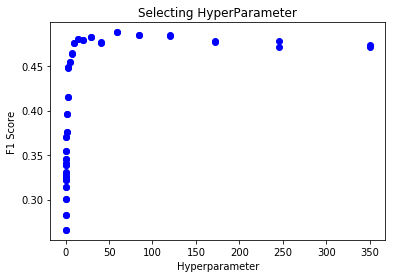

In [15]:
C = 500
f1s=[]
for i in range(0, 30):
    C  *= 0.7
    # print('alpha = '+str(a))
    f1s.append([LinearSVM(trainX, trainY, testX, testY, C,False), C,'False'])
    f1s.append([LinearSVM(trainX, trainY, testX, testY, C,True), C,'True'])
    
f1s.sort()
print('the optimal C is ' + str(f1s[len(f1s) - 1][1]) +', dual= '+str(f1s[len(f1s) - 1][2])+', it achieves a F1 score of ' + str(f1s[len(f1s) - 1][0]))
plotHyperparameterTrainingProgress(np.array(f1s)[:,:-1])

Applying the optimal hyperparameters learnt to the test set.

In [95]:
f1Test = LinearSVM(trainX, trainY, trainX.toarray(), trainY,  58.82449999999997 , True)
print('The F1 score of LinearSVM for yelp train set frequency bag of word representation is '+ str(f1Test))
f1Test = LinearSVM(trainX, trainY, testX, testY,  58.82449999999997 , True)
print('The F1 score of LinearSVM for yelp valid set frequency bag of word representation is '+ str(f1Test))
f1Test = LinearSVM(trainX, trainY, testXFinal, testYFinal,  58.82449999999997 , True)
print('The F1 score of LinearSVM for yelp test set frequency bag of word representation is '+ str(f1Test))

The F1 score of LinearSVM for yelp train set frequency bag of word representation is 0.829556100128
The F1 score of LinearSVM for yelp valid set frequency bag of word representation is 0.486785851558
The F1 score of LinearSVM for yelp test set frequency bag of word representation is 0.499507757732


#### Comment on the result and compare with last question

Linear SVM still perform the best, there is a slight drop in performance in all three classifiers (around 1 percent), I think for language processing the word appears most often are the words that has little meaning like "the", "a", "I". And in the frequency bag of word representation they weighted a lot, althought the classifiers should be able to tell those words have little effect on the result through training, they still affected the result. Also the order of word matters.

### Question4

Get the IMDB train, validation and test data set ready in binary bag of words representation, as well as the scores.

In [16]:
trainResult = readReviews('outputdatasets//IMDB-train.txt')
trainX = getBinaryBagOfWord(trainResult[0])
trainY = trainResult[1]
testResult = readReviews('outputdatasets//IMDB-valid.txt')
testX = getBinaryBagOfWord(testResult[0]).toarray()
testY = testResult[1]
testResultFinal = readReviews('outputdatasets//IMDB-test.txt')
testXFinal = getBinaryBagOfWord(testResultFinal[0]).toarray()
testYFinal = testResultFinal[1]

set the baseline using the random classifier and the majority classifier

In [42]:
randomClassifier(trainX,trainY,testXFinal,testYFinal)

Uniform Random F1 Score= 0.497523170342


In [23]:
def decisionTreeBinaryF1(trainingX, trainingY, testingX, testingY, maxLeaf,min_samples_split, max_features):
    clf = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=maxLeaf, min_samples_split = min_samples_split)
    clf.fit(trainingX, trainingY)
    preditY = []
    for i in range(len(testingX)):
        ans = clf.predict([testingX[i]])
        preditY.append(ans)
    f1Score = metrics.f1_score(testingY, preditY)
    return f1Score

A grid search has been done to find the best combinations of the three hyperparameters. For the maximum number of leaf feature I considered the range from 300 to 100, the maximum feature parameter I considered from .95 to 0.5 the min sample split I considered from 0.5 to 0.0000097

In [24]:
f1s = []
for i in range (300,100,-10):
    max_features = 1.0
    for j in range(10):
        min_sample_split =1
        for k in range (10):
            f1s.append([decisionTreeBinaryF1(trainX,trainY,testX,testY,i,min_sample_split,max_features),i,min_sample_split,max_features])
            min_sample_split *= 0.5
        max_features -= 0.05
f1s.sort()
print('the optimal number of leafs is '+str(f1s[len(f1s)-1][1])+', min sample split is:'
      + str(f1s[len(f1s)-1][2]) +', max features is :'+str(f1s[len(f1s)-1][3])+', it achieves a F1 score of '+ str(f1s[len(f1s)-1][0]))

the optimal number of leafs is 120, min sample split is:0.5, max features is :1.0, it achieves a F1 score of 0.749424405219


Applying the optimal hyperparameters learnt to the test set.

In [25]:
f1Test = decisionTreeBinaryF1(trainX,trainY,trainX.toarray(),trainY,120,0.5,1.0)
print('The F1 score of decision Tree for IMDB train set binary bag of word representation is '+ str(f1Test))
f1Test = decisionTreeBinaryF1(trainX,trainY,testX, testY,120,0.5,1.0)
print('The F1 score of decision Tree for IMDB valid set binary bag of word representation is '+ str(f1Test))
f1Test = decisionTreeBinaryf1s = []
for i in range (300,100,-10):
    max_features = 1.0
    for j in range(10):
        max_features -= 0.05
        min_sample_split =1.0
        for k in range (10):
            f1s.append([decisionTreeBinaryF1(trainX,trainY,testX,testY,i,min_sample_split,max_features),i,min_sample_split,max_features])
            min_sample_split *= 0.5
f1s.sort()
print('the optimal number of leafs is '+str(f1s[len(f1s)-1][1])+', min sample split is:'
      + str(f1s[len(f1s)-1][2]) +', max features is :'+str(f1s[len(f1s)-1][3])+', it achieves a F1 score of '+ str(f1s[len(f1s)-1][0]))F1(trainX,trainY,testXFinal,testYFinal,120,0.5,1.0)
print('The F1 score of decision Tree for IMDB test set binary bag of word representation is '+ str(f1Test))

The F1 score of decision Tree for IMDB train set binary bag of word representation is 0.7335044197319647
The F1 score of decision Tree for IMDB valid set binary bag of word representation is 0.7293072520714102
The F1 score of decision Tree for IMDB test set binary bag of word representation is 0.735850344780501


The function below uses the Bernoulli Native Bayes classifier to classify the data, there is one hyper parameter to be adjusted, which is Additive (Laplace/Lidstone) smoothing parameter, aplha. Alpha will be find in the range of 0.7 to 0.0000225.

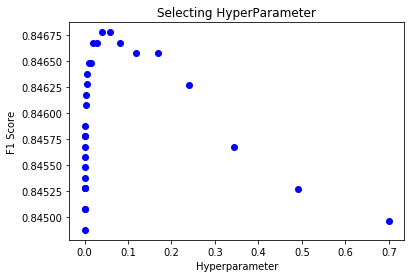

the optimal alpha is 0.04035360699999998, it achieves a F1 score of 0.8467741048237153


In [81]:
f1s = []
a = 1
for i in range(0,30):

    a *=0.7
    # print('alpha = '+str(a))
    f1s.append([BernoulliNativeBayes(trainX, trainY, testX, testY, a), a])
f1s.sort()
plotHyperparameterTrainingProgress(f1s)
print('the optimal alpha is ' + str(f1s[len(f1s)-1][1]) + ', it achieves a F1 score of ' + str(f1s[len(f1s)-1][0]))

Applying the optimal hyperparameters learnt to the test set.

In [78]:
f1Test = BernoulliNativeBayes(trainX,trainY,trainX.toarray(),trainY,0.04035360699999998)
print('The F1 score of Bernoulli Native Bayes for IMDB train set binary bag of word representation is '+ str(f1Test))
f1Test = BernoulliNativeBayes(trainX,trainY,testX,testY,0.04035360699999998)
print('The F1 score of Bernoulli Native Bayes for IMDB valid set binary bag of word representation is '+ str(f1Test))
f1Test = BernoulliNativeBayes(trainX,trainY,testXFinal,testYFinal,0.04035360699999998)
print('The F1 score of Bernoulli Native Bayes for IMDB test set binary bag of word representation is '+ str(f1Test))

The F1 score of Bernoulli Native Bayes for IMDB train set binary bag of word representation is 0.871388945268
The F1 score of Bernoulli Native Bayes for IMDB valid set binary bag of word representation is 0.844782168186
The F1 score of Bernoulli Native Bayes for IMDB test set binary bag of word representation is 0.828050189863


The penalty parameter of the error term C is found below, dual parameter is not considered because according to the documents, dual = False is prefered when the number of samples is larger than the number of features.

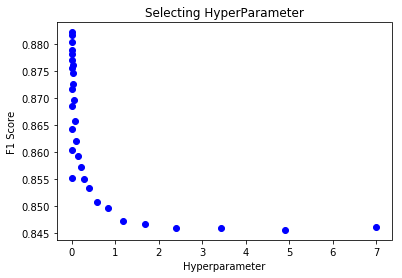

the optimal C is 0.005585458640832834, it achieves a F1 score of 0.8821900285640178


In [17]:
C = 10
f1s=[]
for i in range(0, 30):
    C  *= 0.7
    f1s.append([LinearSVM(trainX, trainY, testX, testY, C,False), C])
f1s.sort()
plotHyperparameterTrainingProgress(f1s)
print('the optimal C is ' + str(f1s[len(f1s) - 1][1]) + ', it achieves a F1 score of ' + str(f1s[len(f1s) - 1][0]))

Applying the optimal hyperparameters learnt to the test set.

In [80]:
f1Test = LinearSVM(trainX, trainY, trainX.toarray(), trainY, 0.005585458640832834,False)
print('The F1 score of LinearSVM for IMDB train set frequency bag of word representation is '+ str(f1Test))
f1Test = LinearSVM(trainX, trainY, testX, testY, 0.005585458640832834,False)
print('The F1 score of LinearSVM for IMDB valid set frequency bag of word representation is '+ str(f1Test))
f1Test = LinearSVM(trainX, trainY, testXFinal, testYFinal, 0.005585458640832834,False)
print('The F1 score of LinearSVM for IMDB test set frequency bag of word representation is '+ str(f1Test))

The F1 score of LinearSVM for IMDB train set frequency bag of word representation is 0.953360313143
The F1 score of LinearSVM for IMDB valid set frequency bag of word representation is 0.883273880301
The F1 score of LinearSVM for IMDB test set frequency bag of word representation is 0.877204130262


### comments

For the IMDB binary bag of word dataset, the linear SVM still perform the best, and the decision tree still perform the worst, all three classifiers are still performing much better than the base line

### In the section below, optimal hyperparameters will be found for the IMDB data sets in Frequency bag of word representation.

Get the IMDB train, validation and test data set ready in frequency bag of words representation, as well as the scores.

In [34]:
trainResult = readReviews('outputdatasets//IMDB-train.txt')
trainX = getFreqBagOfWord(trainResult[0])
trainY = trainResult[1]
testResult = readReviews('outputdatasets//IMDB-valid.txt')
testX = getFreqBagOfWord(testResult[0]).toarray()
testY = testResult[1]
testResultFinal = readReviews('outputdatasets//IMDB-test.txt')
testXFinal = getFreqBagOfWord(testResultFinal[0]).toarray()
testYFinal = testResultFinal[1]

A grid search has been done to find the best combinations of the three hyperparameters. For the maximum number of leaf feature I considered the range from 300 to 100, the maximum feature parameter I considered from .95 to 0.5 the min sample split I considered from 0.5 to 0.0000097

In [25]:
f1s = []
for i in range (300,100,-10):
    max_features = 1.0
    for j in range(10):
        max_features -= 0.05
        min_sample_split =1.0
        for k in range (10):
            f1s.append([decisionTreeBinaryF1(trainX,trainY,testX,testY,i,min_sample_split,max_features),i,min_sample_split,max_features])
            min_sample_split *= 0.5
f1s.sort()
print('the optimal number of leafs is '+str(f1s[len(f1s)-1][1])+', min sample split is:'
      + str(f1s[len(f1s)-1][2]) +', max features is :'+str(f1s[len(f1s)-1][3])+', it achieves a F1 score of '+ str(f1s[len(f1s)-1][0]))

the optimal number of leafs is 300, min sample split is:0.0625, max features is :0.95, it achieves a F1 score of 0.7467424316645439


Applying the optimal hyperparameters learnt to the test set.

In [35]:
f1Test = decisionTreeBinaryF1(trainX,trainY,trainX.toarray(),trainY,300,0.0625,0.95)
print('The F1 score of decision Tree for IMDB train set Frequency bag of word representation is '+ str(f1Test))
f1Test = decisionTreeBinaryF1(trainX,trainY,testX,testY,300,0.0625,0.95)
print('The F1 score of decision Tree for IMDB valid set Frequency bag of word representation is '+ str(f1Test))
f1Test = decisionTreeBinaryF1(trainX,trainY,testXFinal,testYFinal,300,0.0625,0.95)
print('The F1 score of decision Tree for IMDB test set Frequency bag of word representation is '+ str(f1Test))

The F1 score of decision Tree for IMDB train set Frequency bag of word representation is 0.7647251523291618
The F1 score of decision Tree for IMDB valid set Frequency bag of word representation is 0.7467424316645439
The F1 score of decision Tree for IMDB test set Frequency bag of word representation is 0.75


For Gaussian Native Bayes Classifier there is no hyperparameter to be adjusted.

In [86]:
print('Using Gaussian Native Bayes on IMDB train set, F1 score: ' +str(NativeBayesGaussian(trainX, trainY, trainX.toarray(), trainY)))
print('Using Gaussian Native Bayes on IMDB valid set, F1 score: ' +str(NativeBayesGaussian(trainX, trainY, testX, testY)))
print('Using Gaussian Native Bayes on IMDB test set, F1 score: ' +str(NativeBayesGaussian(trainX, trainY, testXFinal, testYFinal)))

Using Gaussian Native Bayes on IMDB train set, F1 score: 0.847282881077
Using Gaussian Native Bayes on IMDB valid set, F1 score: 0.736549363568
Using Gaussian Native Bayes on IMDB test set, F1 score: 0.638794006467


The penalty parameter of the error term C is found below, dual parameter is not considered because according to the documents, dual = False is prefered when the number of samples is larger than the number of features.

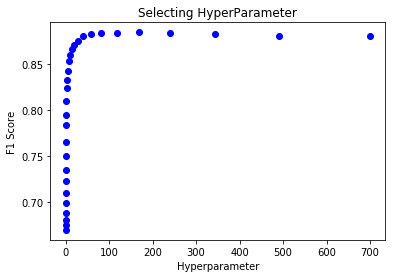

the optimal C is 168.06999999999994, it achieves a F1 score of 0.8842964999691241


In [88]:
C = 1000
f1s=[]
for i in range(0, 30):
    C *=0.7
    # print('alpha = '+str(a))
    f1s.append([LinearSVM(trainX, trainY, testX, testY, C,False), C])
f1s.sort()
plotHyperparameterTrainingProgress(f1s)
print('the optimal C is ' + str(f1s[len(f1s) - 1][1]) + ', it achieves a F1 score of ' + str(f1s[len(f1s) - 1][0]))

Applying the optimal hyperparameters learnt to the test set.

In [101]:
f1Test = LinearSVM(trainX, trainY, trainX.toarray(), trainY, 168.06999999999994, False)
print('The F1 score of LinearSVM for IMDB train set frequency bag of word representation is '+ str(f1Test))
f1Test = LinearSVM(trainX, trainY, testX, testY, 168.06999999999994, False)
print('The F1 score of LinearSVM for IMDB valid set frequency bag of word representation is '+ str(f1Test))
f1Test = LinearSVM(trainX, trainY, testXFinal, testYFinal, 168.06999999999994, False)
print('The F1 score of LinearSVM for IMDB test set frequency bag of word representation is '+ str(f1Test))

The F1 score of LinearSVM for IMDB train set frequency bag of word representation is 0.960559626915
The F1 score of LinearSVM for IMDB valid set frequency bag of word representation is 0.884733963202
The F1 score of LinearSVM for IMDB test set frequency bag of word representation is 0.875855171034


The SVM classifier still performs the best and there are a slight drop in performance in all three classifiers when using frequency bag of words representation, the yelp and IMDB datasets follows the same pattern.